Device: cuda
Adult shapes: (26048, 108) (6513, 108) pos_rate: 0.24082463144963145

Baselines:
           model  test_acc  test_f1_macro  train_time_sec
4      AdaBoost  0.860126       0.790871        6.679626
1  DecisionTree  0.855520       0.797511        0.593323
3  RandomForest  0.854906       0.790149       15.162980
2    SVM_linear  0.854291       0.787469        0.468632
0           KNN  0.849992       0.784525        0.010916
Epoch 01 | train_loss=0.6872 | val_acc=0.7910 | val_f1=0.7593
Epoch 02 | train_loss=0.5895 | val_acc=0.8107 | val_f1=0.7774
Epoch 03 | train_loss=0.5796 | val_acc=0.8079 | val_f1=0.7753
Epoch 04 | train_loss=0.5689 | val_acc=0.8123 | val_f1=0.7792
Epoch 05 | train_loss=0.5601 | val_acc=0.8157 | val_f1=0.7815
Epoch 06 | train_loss=0.5528 | val_acc=0.8084 | val_f1=0.7752
Epoch 07 | train_loss=0.5501 | val_acc=0.8209 | val_f1=0.7865
Epoch 08 | train_loss=0.5470 | val_acc=0.8192 | val_f1=0.7848
Epoch 09 | train_loss=0.5454 | val_acc=0.8154 | val_f1=0.7817
Epoch

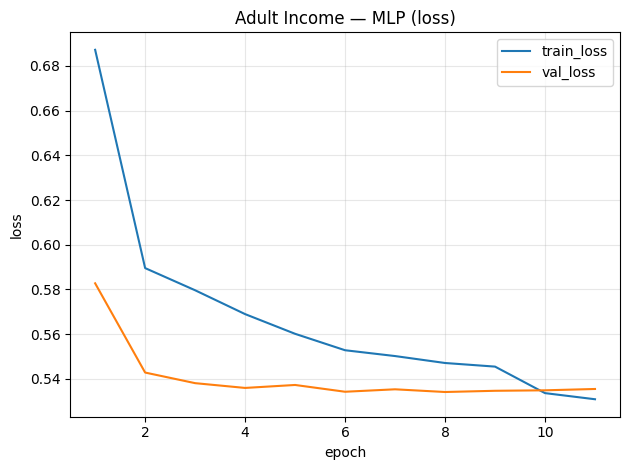

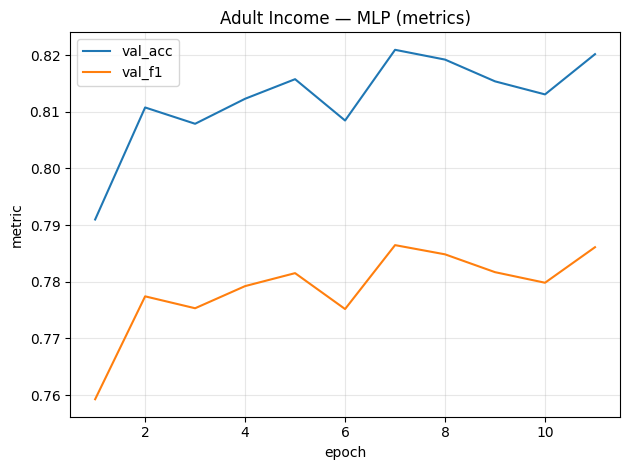

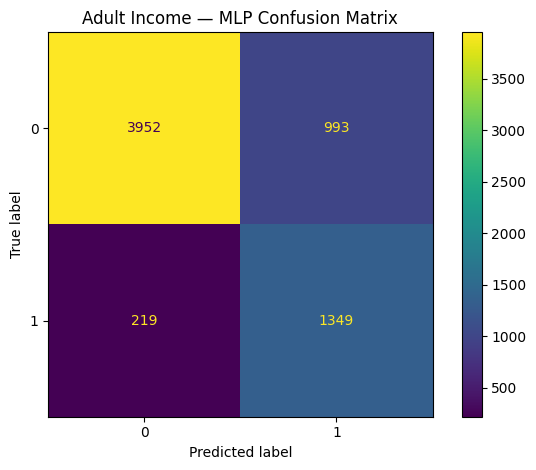


Comparison:
             model  test_acc  test_f1_macro  train_time_sec
0        AdaBoost  0.860126       0.790871        6.679626
1    DecisionTree  0.855520       0.797511        0.593323
2    RandomForest  0.854906       0.790149       15.162980
3      SVM_linear  0.854291       0.787469        0.468632
4             KNN  0.849992       0.784525        0.010916
5  MLP_PyTorch_BN  0.813911       0.778536        4.498907


In [1]:
import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

RANDOM_STATE = 1337
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def plot_history(hist, title):
    epochs = np.arange(1, len(next(iter(hist.values()))) + 1)

    plt.figure()
    if "train_loss" in hist: plt.plot(epochs, hist["train_loss"], label="train_loss")
    if "val_loss" in hist:   plt.plot(epochs, hist["val_loss"], label="val_loss")
    if "train_loss" in hist or "val_loss" in hist:
        plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title + " (loss)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    for k in ["train_acc","val_acc","train_f1","val_f1"]:
        if k in hist: plt.plot(epochs, hist[k], label=k)
    if any(k in hist for k in ["train_acc","val_acc","train_f1","val_f1"]):
        plt.xlabel("epoch"); plt.ylabel("metric"); plt.title(title + " (metrics)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# Load Adult from UCI
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age","workclass","fnlwgt","education","education_num","marital_status",
    "occupation","relationship","race","sex","capital_gain","capital_loss",
    "hours_per_week","native_country","income"
]
df = pd.read_csv(data_url, header=None, names=column_names, na_values=" ?", skipinitialspace=True).dropna()

X = df.drop("income", axis=1)
y = (df["income"].str.strip() == ">50K").astype(int).values

num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

Xtr = preprocessor.fit_transform(X_train)
Xte = preprocessor.transform(X_test)

if hasattr(Xtr, "toarray"):
    Xtr = Xtr.toarray()
    Xte = Xte.toarray()

Xtr = Xtr.astype(np.float32)
Xte = Xte.astype(np.float32)

print("Adult shapes:", Xtr.shape, Xte.shape, "pos_rate:", float(y_train.mean()))

#  Baselines
baselines = {
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=14),
    "SVM_linear": LinearSVC(random_state=RANDOM_STATE, max_iter=4000),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE, n_estimators=200, learning_rate=0.8),
}

rows = []
for name, clf in baselines.items():
    t0 = time.time()
    clf.fit(Xtr, y_train)
    dt = time.time() - t0
    pred = clf.predict(Xte)
    acc = accuracy_score(y_test, pred)
    f1m = f1_score(y_test, pred, average="macro")
    rows.append([name, acc, f1m, dt])

df_base = pd.DataFrame(rows, columns=["model","test_acc","test_f1_macro","train_time_sec"]).sort_values("test_acc", ascending=False)
print("\nBaselines:\n", df_base)

# MLP (PyTorch) + history + confusion matrix
Xtr2, Xval, ytr2, yval = train_test_split(Xtr, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr2), torch.from_numpy(ytr2)), batch_size=512, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.from_numpy(Xval), torch.from_numpy(yval)), batch_size=1024, shuffle=False)
test_loader  = DataLoader(TensorDataset(torch.from_numpy(Xte),  torch.from_numpy(y_test)), batch_size=1024, shuffle=False)

class AdultMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

mlp = AdultMLP(Xtr.shape[1]).to(device)

pos = int((ytr2 == 1).sum())
neg = int((ytr2 == 0).sum())
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1)

@torch.no_grad()
def eval_mlp(loader):
    mlp.eval()
    ys, ps = [], []
    loss_sum, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb_f = yb.to(device).float()
        logits = mlp(xb)
        loss = criterion(logits, yb_f)
        probs = torch.sigmoid(logits).cpu().numpy()
        pred = (probs >= 0.5).astype(int)
        ys.append(yb.numpy()); ps.append(pred)
        bs = xb.size(0)
        loss_sum += loss.item() * bs
        n += bs
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    return (loss_sum / max(n,1)), acc, f1m, y_true, y_pred

hist = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}
best_val = -1.0
best_state = None
bad = 0
patience = 4

t0 = time.time()
for ep in range(1, 26):
    mlp.train()
    loss_sum, n = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float()
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(mlp(xb), yb)
        loss.backward()
        optimizer.step()
        bs = xb.size(0)
        loss_sum += loss.item() * bs
        n += bs

    train_loss = loss_sum / max(n,1)
    val_loss, val_acc, val_f1, _, _ = eval_mlp(val_loader)
    scheduler.step(val_f1)

    hist["train_loss"].append(train_loss)
    hist["val_loss"].append(val_loss)
    hist["val_acc"].append(val_acc)
    hist["val_f1"].append(val_f1)

    print(f"Epoch {ep:02d} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f} | val_f1={val_f1:.4f}")

    if val_f1 > best_val + 1e-4:
        best_val = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in mlp.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            break

train_time = time.time() - t0
mlp.load_state_dict(best_state); mlp.to(device)

test_loss, test_acc, test_f1, y_true, y_pred = eval_mlp(test_loader)
print("\nMLP TEST acc:", test_acc, "MLP TEST f1_macro:", test_f1, "train_time_sec:", train_time)
print(classification_report(y_true, y_pred))

plot_history(hist, "Adult Income — MLP")

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Adult Income — MLP Confusion Matrix")
plt.tight_layout()
plt.show()

df_cmp = pd.concat([df_base, pd.DataFrame([["MLP_PyTorch_BN", test_acc, test_f1, train_time]],
                                         columns=["model","test_acc","test_f1_macro","train_time_sec"])],
                   ignore_index=True).sort_values("test_acc", ascending=False).reset_index(drop=True)
print("\nComparison:\n", df_cmp)


MLP на Adult дав test accuracy 0.814 і macro-F1 0.779, що нижче за всі baseline-алгоритми з першої лаборатоної. На графіку видно, що валідаційні метрики ростуть до ~7–11 епохи, без явного розвалу, тобто модель навчилась і збігається стабільно, але її узагальнююча здатність на тесті гірша.
З матриці плутанини видно перекіс у бік знаходження позитивного класу. Модель часто підозрює >50K, тому ловить більшість справжніх позитивів, але платить великою кількістю хибних спрацювань.

Device: cuda


100%|██████████| 345M/345M [00:13<00:00, 25.0MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.93MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 45.5MB/s]


Flowers102 sizes: 1020 1020 6149


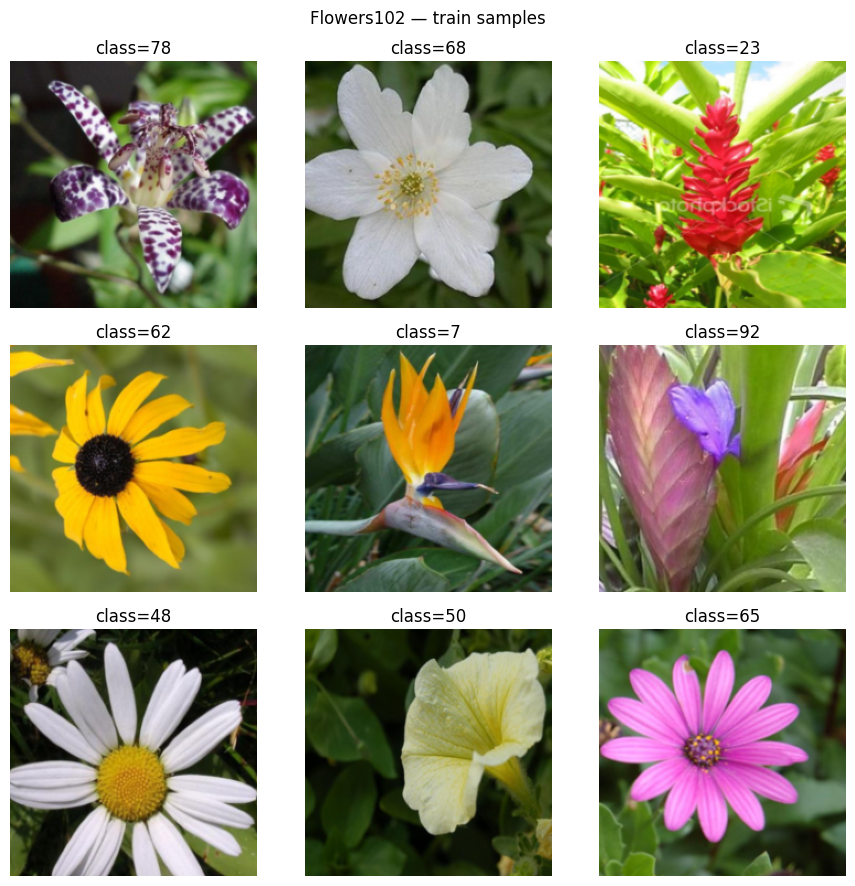


DATA FRACTION: 0.1 train_n= 102
Epoch 01 | train_loss=4.6131 | val_acc=0.0216 | val_loss=4.6203
Epoch 02 | train_loss=3.6330 | val_acc=0.0255 | val_loss=4.6244
Epoch 03 | train_loss=3.1028 | val_acc=0.0265 | val_loss=4.6452
Epoch 04 | train_loss=2.7242 | val_acc=0.0275 | val_loss=4.6722
Epoch 05 | train_loss=2.4774 | val_acc=0.0363 | val_loss=4.7022
Epoch 06 | train_loss=2.3199 | val_acc=0.0373 | val_loss=4.7274
Epoch 07 | train_loss=2.2331 | val_acc=0.0392 | val_loss=4.7524
Epoch 08 | train_loss=2.1817 | val_acc=0.0402 | val_loss=4.7813


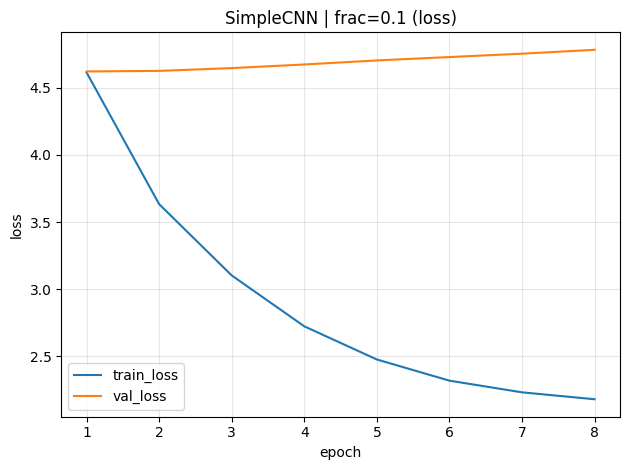

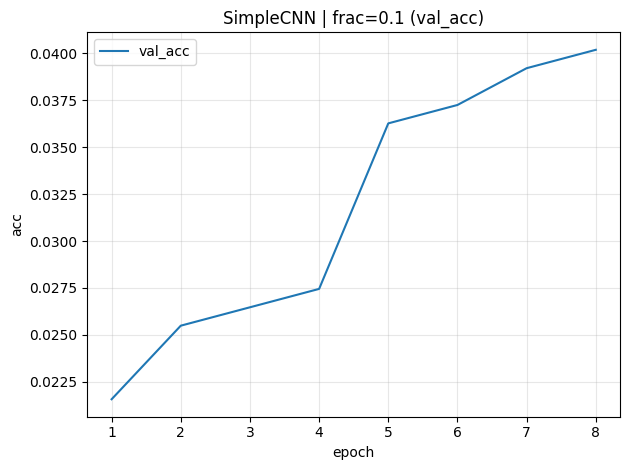

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


Epoch 01 | train_loss=4.4879 | val_acc=0.0343 | val_loss=4.6247
Epoch 02 | train_loss=3.8954 | val_acc=0.0520 | val_loss=4.6445
Epoch 03 | train_loss=3.4719 | val_acc=0.0598 | val_loss=4.6756
Epoch 04 | train_loss=3.2500 | val_acc=0.0598 | val_loss=4.6969


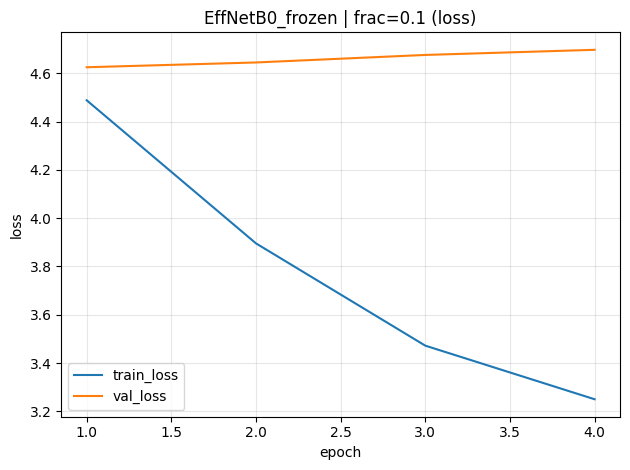

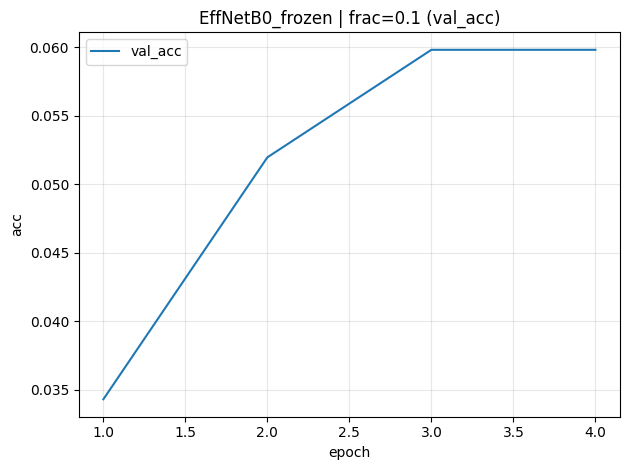

Epoch 01 | train_loss=3.2401 | val_acc=0.0755 | val_loss=4.7366
Epoch 02 | train_loss=2.8911 | val_acc=0.0804 | val_loss=4.8140
Epoch 03 | train_loss=2.6560 | val_acc=0.0794 | val_loss=4.8561
Epoch 04 | train_loss=2.5789 | val_acc=0.0794 | val_loss=4.8517


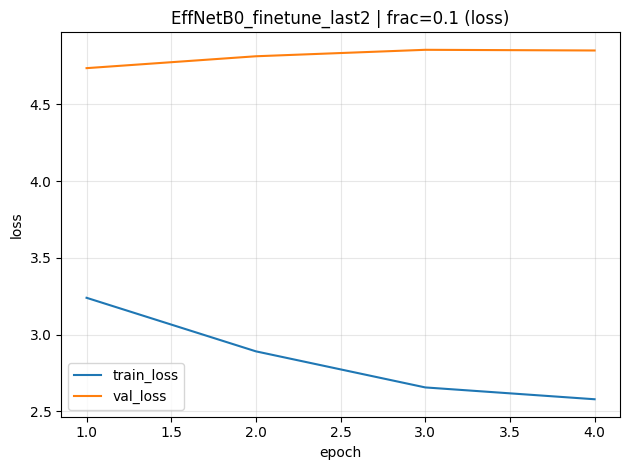

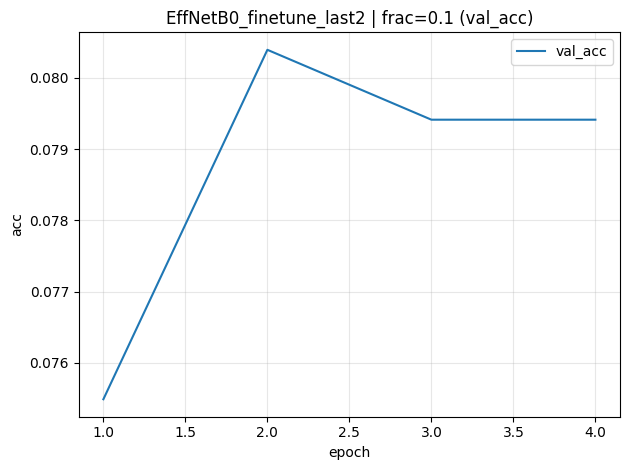


DATA FRACTION: 0.3 train_n= 306
Epoch 01 | train_loss=4.3753 | val_acc=0.0382 | val_loss=4.6172
Epoch 02 | train_loss=3.5959 | val_acc=0.0431 | val_loss=4.7808
Epoch 03 | train_loss=3.2417 | val_acc=0.0451 | val_loss=4.9815
Epoch 04 | train_loss=2.9819 | val_acc=0.0735 | val_loss=5.1502
Epoch 05 | train_loss=2.8534 | val_acc=0.0804 | val_loss=5.2745
Epoch 06 | train_loss=2.7724 | val_acc=0.0873 | val_loss=5.3888
Epoch 07 | train_loss=2.7297 | val_acc=0.0941 | val_loss=5.4923
Epoch 08 | train_loss=2.7045 | val_acc=0.1010 | val_loss=5.5723


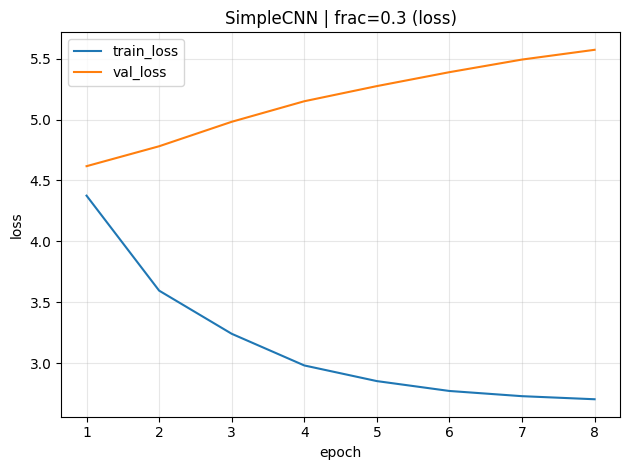

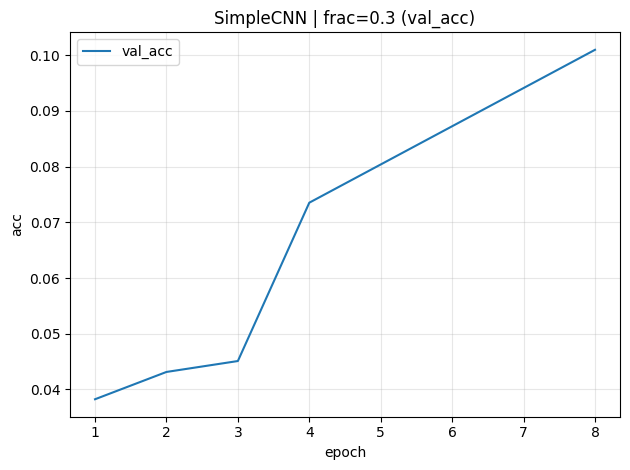

Epoch 01 | train_loss=4.3278 | val_acc=0.0647 | val_loss=4.5962
Epoch 02 | train_loss=3.4724 | val_acc=0.1755 | val_loss=4.7275
Epoch 03 | train_loss=3.0084 | val_acc=0.2137 | val_loss=4.8487
Epoch 04 | train_loss=2.7936 | val_acc=0.2157 | val_loss=4.9031


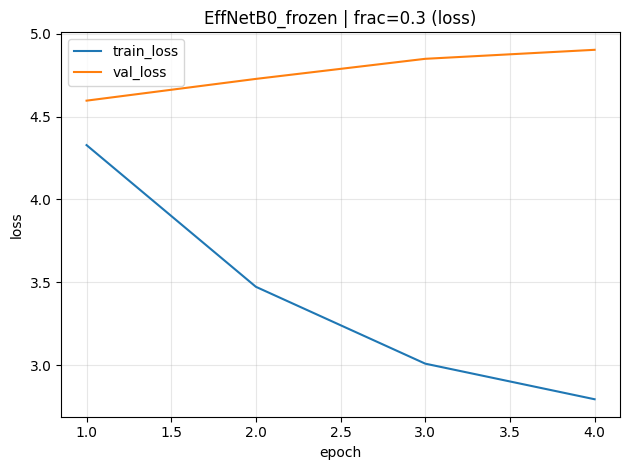

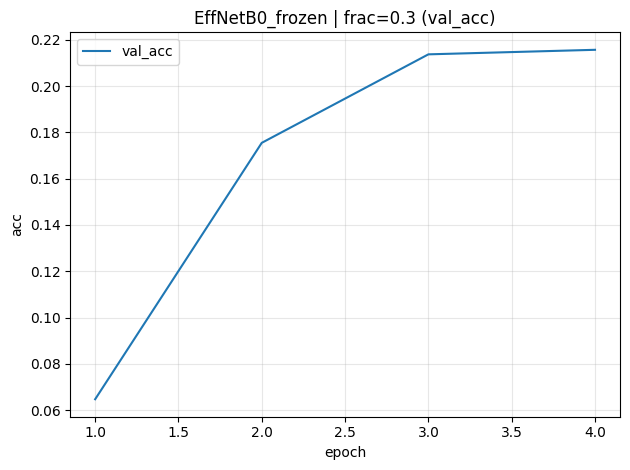

Epoch 01 | train_loss=2.6611 | val_acc=0.2265 | val_loss=5.3524
Epoch 02 | train_loss=2.2593 | val_acc=0.2373 | val_loss=5.6593
Epoch 03 | train_loss=2.0288 | val_acc=0.2431 | val_loss=5.6538
Epoch 04 | train_loss=1.9277 | val_acc=0.2441 | val_loss=5.5076


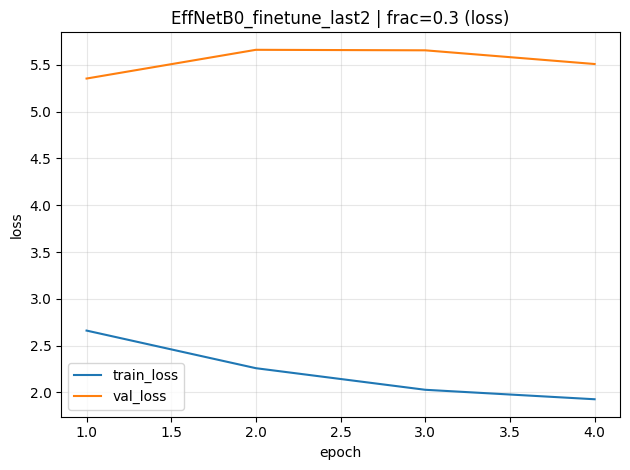

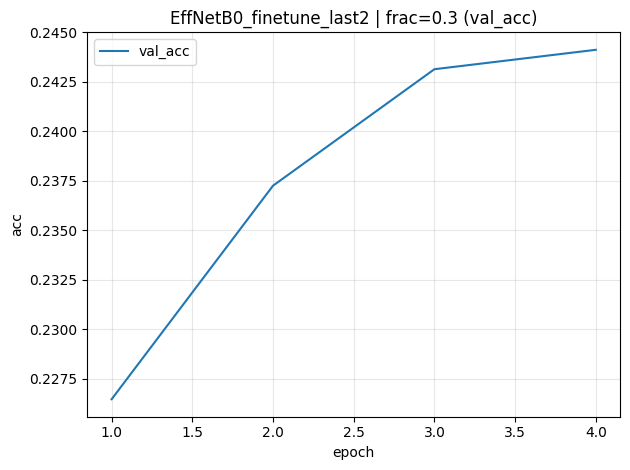


DATA FRACTION: 1.0 train_n= 1020
Epoch 01 | train_loss=4.6119 | val_acc=0.0382 | val_loss=4.3227
Epoch 02 | train_loss=4.2419 | val_acc=0.0598 | val_loss=4.0689
Epoch 03 | train_loss=4.0314 | val_acc=0.1020 | val_loss=3.9102
Epoch 04 | train_loss=3.9191 | val_acc=0.1275 | val_loss=3.7971
Epoch 05 | train_loss=3.7912 | val_acc=0.1480 | val_loss=3.7505
Epoch 06 | train_loss=3.7097 | val_acc=0.1500 | val_loss=3.6895
Epoch 07 | train_loss=3.6486 | val_acc=0.1676 | val_loss=3.6573
Epoch 08 | train_loss=3.6427 | val_acc=0.1676 | val_loss=3.6444


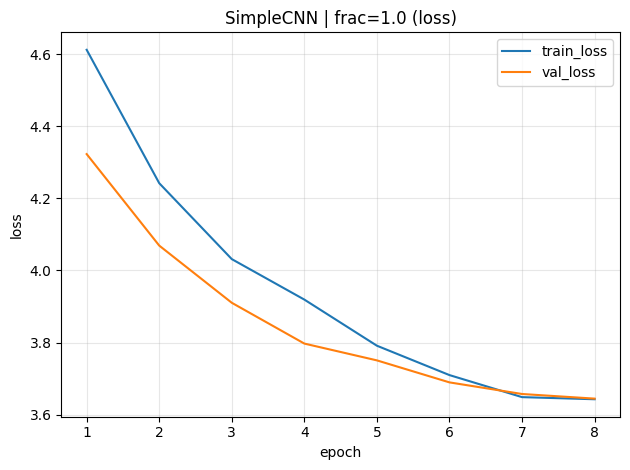

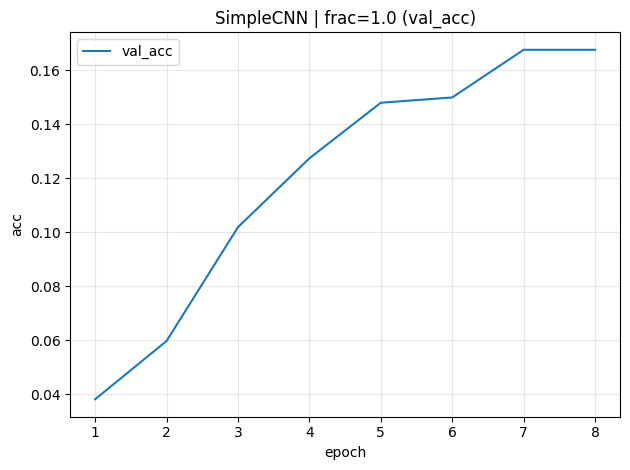

Epoch 01 | train_loss=4.4507 | val_acc=0.3716 | val_loss=3.8865
Epoch 02 | train_loss=3.4894 | val_acc=0.6618 | val_loss=3.3084
Epoch 03 | train_loss=2.9261 | val_acc=0.7127 | val_loss=3.0352
Epoch 04 | train_loss=2.6456 | val_acc=0.7245 | val_loss=2.9574


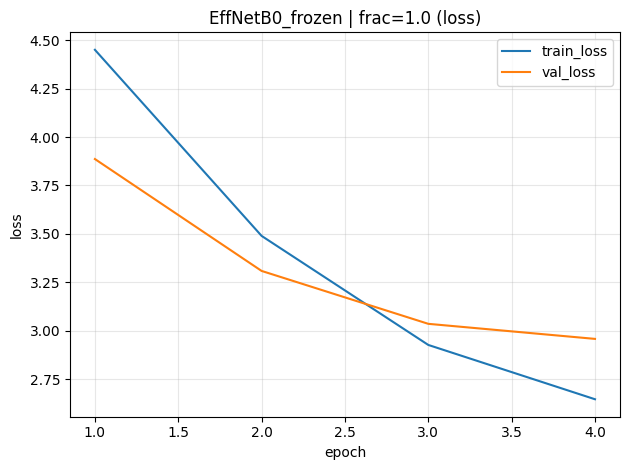

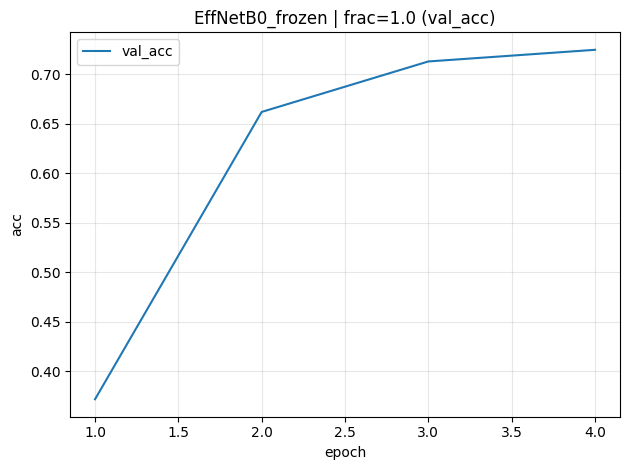

Epoch 01 | train_loss=2.3685 | val_acc=0.7559 | val_loss=2.1990
Epoch 02 | train_loss=1.8589 | val_acc=0.7686 | val_loss=2.0180
Epoch 03 | train_loss=1.6032 | val_acc=0.7833 | val_loss=1.9661
Epoch 04 | train_loss=1.4800 | val_acc=0.7863 | val_loss=1.9354


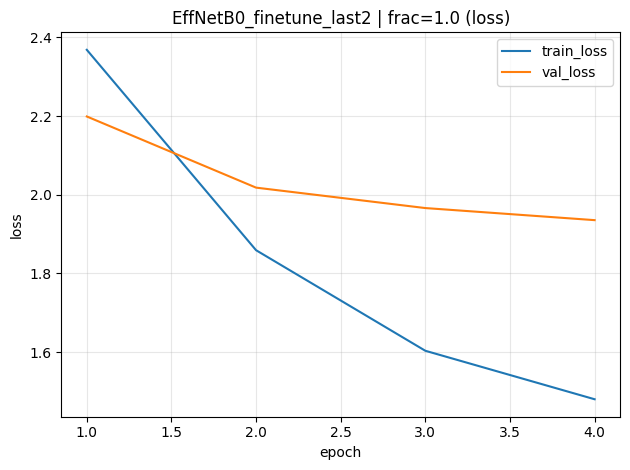

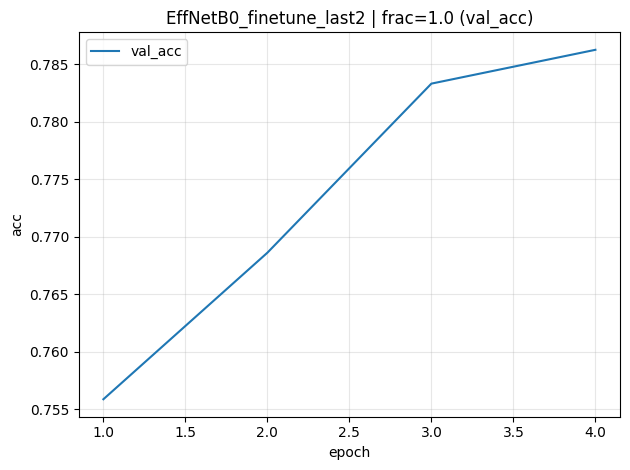


RESULTS:
                      model  data_fraction  best_val_acc  test_acc  \
0  EffNetB0_finetune_last2            0.1      0.080392  0.042283   
1          EffNetB0_frozen            0.1      0.059804  0.034965   
2                SimpleCNN            0.1      0.040196  0.019190   
3  EffNetB0_finetune_last2            0.3      0.244118  0.151407   
4          EffNetB0_frozen            0.3      0.215686  0.132705   
5                SimpleCNN            0.3      0.100980  0.061961   
6  EffNetB0_finetune_last2            1.0      0.786275  0.752317   
7          EffNetB0_frozen            1.0      0.724510  0.692633   
8                SimpleCNN            1.0      0.167647  0.144088   

   train_time_sec  epochs_ran  
0       28.861422           4  
1       35.420631           4  
2       55.365956           8  
3       35.558660           4  
4       37.344473           4  
5       65.724503           8  
6       57.027992           4  
7       57.790518           4  
8      133

In [2]:
import time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from torchvision import datasets, transforms, models

RANDOM_STATE = 1337
random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE); torch.manual_seed(RANDOM_STATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def plot_history(hist, title):
    epochs = np.arange(1, len(next(iter(hist.values()))) + 1)

    plt.figure()
    if "train_loss" in hist: plt.plot(epochs, hist["train_loss"], label="train_loss")
    if "val_loss" in hist:   plt.plot(epochs, hist["val_loss"], label="val_loss")
    if "train_loss" in hist or "val_loss" in hist:
        plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title + " (loss)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    if "val_acc" in hist: plt.plot(epochs, hist["val_acc"], label="val_acc")
    plt.xlabel("epoch"); plt.ylabel("acc"); plt.title(title + " (val_acc)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

tf_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
tf_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

root = "./data_flowers102"
ds_train = datasets.Flowers102(root=root, split="train", download=True, transform=tf_train)
ds_val   = datasets.Flowers102(root=root, split="val",   download=True, transform=tf_eval)
ds_test  = datasets.Flowers102(root=root, split="test",  download=True, transform=tf_eval)
num_classes = 102
print("Flowers102 sizes:", len(ds_train), len(ds_val), len(ds_test))

def unnormalize_img(t, mean, std):
    out = t.clone().cpu()
    for c in range(3):
        out[c] = out[c] * std[c] + mean[c]
    return out.clamp(0, 1)

def show_samples(ds, k=9, title="Samples"):
    idx = np.random.choice(len(ds), size=k, replace=False)
    cols = int(np.sqrt(k)); rows = int(np.ceil(k / cols))
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, j in enumerate(idx):
        x, y = ds[j]
        x_vis = unnormalize_img(x, imagenet_mean, imagenet_std)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.transpose(x_vis.numpy(), (1,2,0)))
        plt.title(f"class={int(y)}")
        plt.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_samples(ds_train, k=9, title="Flowers102 — train samples")

def make_loaders(train_subset, val_ds, test_ds, bs=64, nw=2):
    tr = DataLoader(train_subset, batch_size=bs, shuffle=True, num_workers=nw, pin_memory=True)
    va = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)
    te = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)
    return tr, va, te

@torch.no_grad()
def eval_ce(model, loader):
    model.eval()
    crit = nn.CrossEntropyLoss()
    loss_sum, acc_sum, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = crit(logits, yb)
        bs = xb.size(0)
        loss_sum += loss.item() * bs
        acc_sum  += (logits.argmax(1) == yb).float().sum().item()
        n += bs
    return loss_sum / max(n,1), acc_sum / max(n,1)

def train_ce_with_history(model, tr_loader, va_loader, epochs=6, lr=1e-3, wd=1e-4, patience=2, amp=True):
    model.to(device)
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(epochs, 1))

    scaler = torch.amp.GradScaler("cuda", enabled=(amp and device.type=="cuda"))

    best_acc = -1.0
    best_state = None
    bad = 0
    hist = {"train_loss": [], "val_loss": [], "val_acc": []}
    t0 = time.time()
    epochs_ran = 0

    for ep in range(1, epochs + 1):
        epochs_ran = ep
        model.train()
        loss_sum, n = 0.0, 0

        for xb, yb in tr_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(amp and device.type=="cuda")):
                logits = model(xb)
                loss = crit(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            bs = xb.size(0)
            loss_sum += loss.item() * bs
            n += bs

        sched.step()
        train_loss = loss_sum / max(n,1)
        val_loss, val_acc = eval_ce(model, va_loader)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)

        print(f"Epoch {ep:02d} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f} | val_loss={val_loss:.4f}")

        if val_acc > best_acc + 1e-4:
            best_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    dt = time.time() - t0
    model.load_state_dict(best_state); model.to(device)
    return model, hist, dt, epochs_ran, best_acc

# SimpleCNN (3 conv + FC)
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Dropout(0.35), nn.Linear(128, n_classes))
    def forward(self, x):
        return self.head(self.feat(x))

#  EfficientNet-B0 pretrained
def efficientnet_b0_head(n_classes, freeze=True):
    m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    if freeze:
        for p in m.features.parameters():
            p.requires_grad = False
    in_f = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_f, n_classes)
    return m

def unfreeze_last_eff_blocks(m, n_last=2):
    blocks = list(m.features.children())
    for b in blocks[-n_last:]:
        for p in b.parameters():
            p.requires_grad = True

fractions = [0.1, 0.3, 1.0]
all_idx = np.arange(len(ds_train))
results = []

histories = {}  # (model, frac) -> hist for plotting

for frac in fractions:
    n_tr = max(1, int(len(all_idx) * frac))
    tr_idx = all_idx[:n_tr]
    tr_subset = Subset(ds_train, tr_idx)
    trL, vaL, teL = make_loaders(tr_subset, ds_val, ds_test, bs=64, nw=2)

    print("\n==============================")
    print("DATA FRACTION:", frac, "train_n=", n_tr)
    print("==============================")

    # (a) SimpleCNN
    m1 = SimpleCNN(num_classes)
    m1, h1, t1, e1, bva1 = train_ce_with_history(m1, trL, vaL, epochs=8, lr=2e-3, patience=3, amp=True)
    te_loss, te_acc = eval_ce(m1, teL)
    results.append(["SimpleCNN", frac, bva1, te_acc, t1, e1])
    histories[("SimpleCNN", frac)] = h1
    plot_history(h1, f"SimpleCNN | frac={frac}")

    # (b1) EfficientNet frozen
    m2 = efficientnet_b0_head(num_classes, freeze=True)
    m2, h2, t2, e2, bva2 = train_ce_with_history(m2, trL, vaL, epochs=4, lr=1e-3, patience=2, amp=True)
    te_loss, te_acc = eval_ce(m2, teL)
    results.append(["EffNetB0_frozen", frac, bva2, te_acc, t2, e2])
    histories[("EffNetB0_frozen", frac)] = h2
    plot_history(h2, f"EffNetB0_frozen | frac={frac}")

    # (b2) EfficientNet finetune last2
    unfreeze_last_eff_blocks(m2, n_last=2)
    m2, h3, t3, e3, bva3 = train_ce_with_history(m2, trL, vaL, epochs=4, lr=2e-4, patience=2, amp=True)
    te_loss, te_acc = eval_ce(m2, teL)
    results.append(["EffNetB0_finetune_last2", frac, bva3, te_acc, t3, e3])
    histories[("EffNetB0_finetune_last2", frac)] = h3
    plot_history(h3, f"EffNetB0_finetune_last2 | frac={frac}")

df_cnn = pd.DataFrame(results, columns=["model","data_fraction","best_val_acc","test_acc","train_time_sec","epochs_ran"])
df_cnn = df_cnn.sort_values(["data_fraction","test_acc"], ascending=[True, False]).reset_index(drop=True)
print("\nRESULTS:\n", df_cnn)


На малих підвибірках даних модель SimpleCNN практично не вчиться, при fraction 0.1 вона піднімає val acc лише з 0.0216 до 0.0402 і на тесті дає 0.0192, при fraction 0.3 val acc росте до 0.1010 і тест 0.0620, при цьому на графіках видно що train loss падає, а val loss росте, це означає перенавчання на дуже малій кількості прикладів і відсутність узагальнення. Pretrained EfficientNet працює краще навіть на малих даних, при fraction 0.1 frozen дає best val acc 0.0598 і тест 0.0350, а finetune last2 дає best val acc 0.0804 і тест 0.0423, при fraction 0.3 frozen дає best val acc 0.2157 і тест 0.1327, а finetune last2 дає best val acc 0.2441 і тест 0.1514, тобто transfer learning реально переносить ознаки і дає приріст якості, хоча абсолютні значення все ще низькі через дуже малу кількість даних і велику кількість класів. На графіках loss для pretrained також видно, що val loss може рости навіть коли train loss падає, це означає що за малої вибірки модель швидко починає підлаштовуватись під train, тому рання зупинка і сильніші регуляризації тут критичні. На повній вибірці fraction 1.0 різниця стає принциповою, SimpleCNN доходить лише до best val acc 0.1676 і тест 0.1441, тоді як EfficientNet frozen дає best val acc 0.7245 і тест 0.6926, а EfficientNet finetune last2 дає best val acc 0.7863 і тест 0.7523, тобто pretrained модель дає різко кращу якість і швидше збігається за 4 епохи. За часом SimpleCNN найдовший і при цьому найгірший, для fraction 1.0 це 133 секунди проти 57 секунд у pretrained. Проста CNN без попереднього навчання погано працює на Flowers102, а transfer learning є обов’язковим для прийнятної точності, особливо якщо даних мало.


Device: cuda
Classes: ['rec.sport.hockey', 'sci.space'] N= 1986
vocab_size: 9667

=== (A) Random Embedding (trainable) + GRU ===
Epoch 01 | train_loss=0.6919 | val_acc=0.5283 | val_f1=0.5241
Epoch 02 | train_loss=0.6603 | val_acc=0.5535 | val_f1=0.5528
Epoch 03 | train_loss=0.6070 | val_acc=0.6981 | val_f1=0.6937
Epoch 04 | train_loss=0.4596 | val_acc=0.7484 | val_f1=0.7483
Epoch 05 | train_loss=0.3590 | val_acc=0.7893 | val_f1=0.7891
Epoch 06 | train_loss=0.2873 | val_acc=0.7987 | val_f1=0.7986
Epoch 07 | train_loss=0.2094 | val_acc=0.8270 | val_f1=0.8269
Epoch 08 | train_loss=0.1705 | val_acc=0.8333 | val_f1=0.8326
Epoch 09 | train_loss=0.1256 | val_acc=0.8333 | val_f1=0.8333
Epoch 10 | train_loss=0.1000 | val_acc=0.8270 | val_f1=0.8270
Epoch 11 | train_loss=0.0746 | val_acc=0.8428 | val_f1=0.8425
Epoch 12 | train_loss=0.0741 | val_acc=0.8050 | val_f1=0.8050
TEST acc: 0.8894472361809045 TEST f1_macro: 0.8893466447617844 train_time_sec: 6.77905011177063
                  precision    

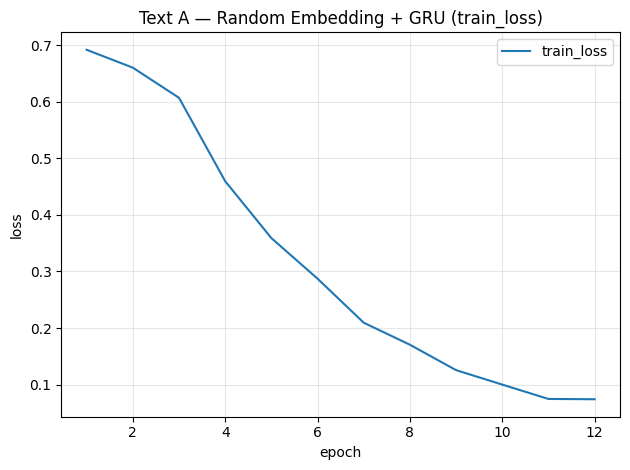

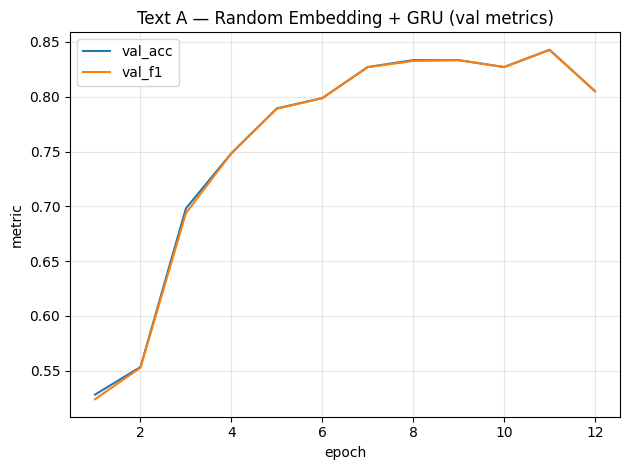

GloVe hit rate: 9081 / 9667

=== (B1) GloVe Embedding (frozen) + GRU ===
Epoch 01 | train_loss=0.6178 | val_acc=0.7704 | val_f1=0.7690
Epoch 02 | train_loss=0.3372 | val_acc=0.8931 | val_f1=0.8927
Epoch 03 | train_loss=0.1911 | val_acc=0.9277 | val_f1=0.9277
Epoch 04 | train_loss=0.1474 | val_acc=0.9182 | val_f1=0.9182
Epoch 05 | train_loss=0.1429 | val_acc=0.9119 | val_f1=0.9118
Epoch 06 | train_loss=0.1333 | val_acc=0.9214 | val_f1=0.9214
TEST acc: 0.9321608040201005 TEST f1_macro: 0.9321603757504593 train_time_sec: 2.574056386947632
                  precision    recall  f1-score   support

rec.sport.hockey       0.94      0.93      0.93       200
       sci.space       0.93      0.94      0.93       198

        accuracy                           0.93       398
       macro avg       0.93      0.93      0.93       398
    weighted avg       0.93      0.93      0.93       398



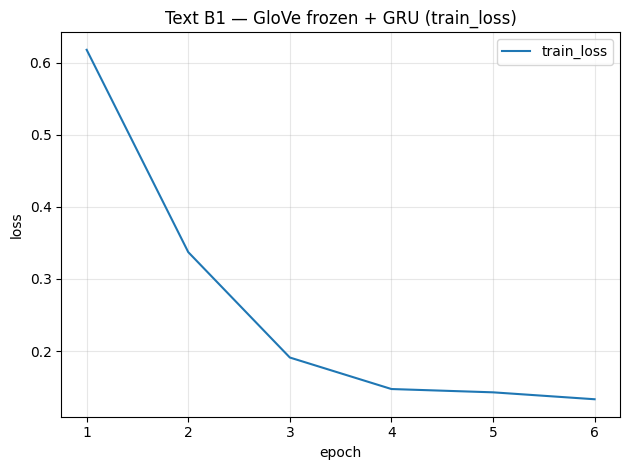

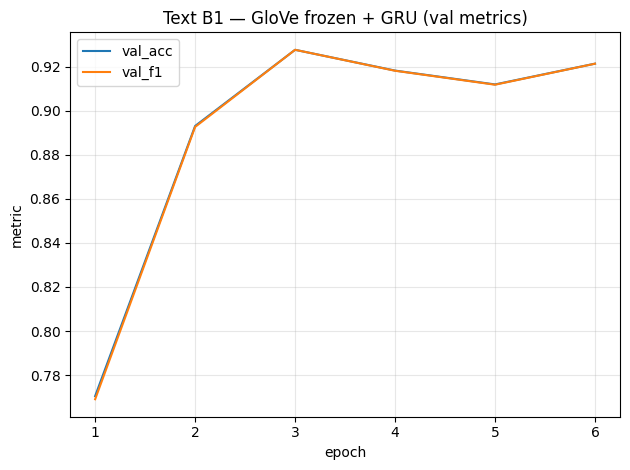


=== (B2) GloVe Embedding (trainable) + GRU ===
Epoch 01 | train_loss=0.6529 | val_acc=0.7358 | val_f1=0.7356
Epoch 02 | train_loss=0.3944 | val_acc=0.8805 | val_f1=0.8802
Epoch 03 | train_loss=0.2528 | val_acc=0.8899 | val_f1=0.8899
Epoch 04 | train_loss=0.1497 | val_acc=0.9088 | val_f1=0.9085
Epoch 05 | train_loss=0.1336 | val_acc=0.9057 | val_f1=0.9053
Epoch 06 | train_loss=0.1075 | val_acc=0.9371 | val_f1=0.9371
Epoch 07 | train_loss=0.0939 | val_acc=0.9182 | val_f1=0.9182
Epoch 08 | train_loss=0.0919 | val_acc=0.9245 | val_f1=0.9245
Epoch 09 | train_loss=0.0820 | val_acc=0.9340 | val_f1=0.9339
TEST acc: 0.9422110552763819 TEST f1_macro: 0.9422077717099656 train_time_sec: 5.061793804168701
                  precision    recall  f1-score   support

rec.sport.hockey       0.94      0.94      0.94       200
       sci.space       0.94      0.94      0.94       198

        accuracy                           0.94       398
       macro avg       0.94      0.94      0.94       398
    w

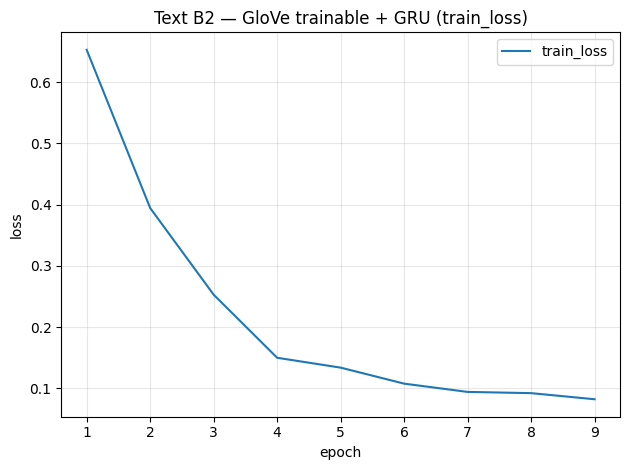

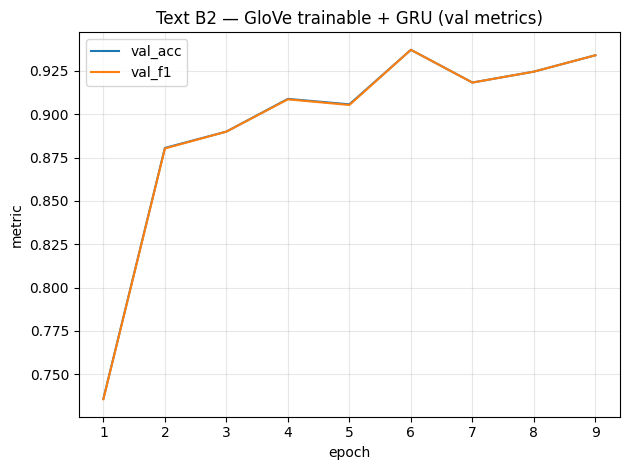


SUMMARY:
                 model  test_acc  test_f1_macro  train_time_sec
2  B2_glove_trainable  0.942211       0.942208        5.061794
1     B1_glove_frozen  0.932161       0.932160        2.574056
0  A_random_trainable  0.889447       0.889347        6.779050


In [ ]:
import os, re, time, zipfile, urllib.request, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

RANDOM_STATE = 1337
random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE); torch.manual_seed(RANDOM_STATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def plot_history(hist, title):
    epochs = np.arange(1, len(next(iter(hist.values()))) + 1)
    plt.figure()
    if "train_loss" in hist: plt.plot(epochs, hist["train_loss"], label="train_loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title + " (train_loss)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    for k in ["val_acc","val_f1"]:
        if k in hist: plt.plot(epochs, hist[k], label=k)
    plt.xlabel("epoch"); plt.ylabel("metric"); plt.title(title + " (val metrics)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

#  Load dataset (Lab2 style)
categories = ["rec.sport.hockey", "sci.space"]
ng = fetch_20newsgroups(subset="all", categories=categories, remove=("headers","footers","quotes"))
texts = ng.data
labels = np.array(ng.target, dtype=np.int64)
target_names = ng.target_names
print("Classes:", target_names, "N=", len(texts))

X_tr, X_te, y_tr, y_te = train_test_split(texts, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.2, random_state=RANDOM_STATE, stratify=y_tr)

#  Tokenizer + vocab
token_re = re.compile(r"[a-z']+")
def tokenize(s: str):
    return token_re.findall(s.lower())

from collections import Counter
max_vocab = 20000
min_freq = 2

cnt = Counter()
for t in X_tr:
    cnt.update(tokenize(t))

vocab = {"<pad>": 0, "<unk>": 1}
for w, c in cnt.most_common():
    if c < min_freq:
        continue
    if w in vocab:
        continue
    vocab[w] = len(vocab)
    if len(vocab) >= max_vocab:
        break

pad_id = vocab["<pad>"]
unk_id = vocab["<unk>"]
vocab_size = len(vocab)
max_len = 300
print("vocab_size:", vocab_size)

def encode(text):
    ids = [vocab.get(w, unk_id) for w in tokenize(text)]
    ids = ids[:max_len]
    length = len(ids)
    if length < max_len:
        ids = ids + [pad_id] * (max_len - length)
    return np.array(ids, dtype=np.int64), length

class TxtDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = np.array(y, dtype=np.int64)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        x_ids, length = encode(self.X[i])
        return torch.tensor(x_ids), torch.tensor(length), torch.tensor(self.y[i])

dl_tr = DataLoader(TxtDS(X_tr, y_tr), batch_size=64, shuffle=True)
dl_va = DataLoader(TxtDS(X_va, y_va), batch_size=128, shuffle=False)
dl_te = DataLoader(TxtDS(X_te, y_te), batch_size=128, shuffle=False)

# Model
class EmbGRU(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden=128, num_classes=2, pad_id=0, dropout=0.3, freeze_emb=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        if freeze_emb:
            self.embedding.weight.requires_grad = False
        self.gru = nn.GRU(emb_dim, hidden, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, num_classes)
    def forward(self, x, lengths):
        emb = self.embedding(x)
        lengths = torch.clamp(lengths, min=1).cpu()
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        _, h = self.gru(packed)
        h = h.squeeze(0)
        return self.fc(self.drop(h))

@torch.no_grad()
def eval_text(model, loader):
    model.eval()
    ys, ps = [], []
    for x, lengths, y in loader:
        x = x.to(device); lengths = lengths.to(device); y = y.to(device)
        logits = model(x, lengths)
        pred = logits.argmax(1)
        ys.append(y.cpu().numpy())
        ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    return acc, f1m, y_true, y_pred

def train_text_with_history(model, epochs=10, lr=1e-3, patience=3):
    model.to(device)
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()

    best = -1.0
    best_state = None
    bad = 0
    hist = {"train_loss": [], "val_acc": [], "val_f1": []}
    t0 = time.time()

    for ep in range(1, epochs + 1):
        model.train()
        loss_sum, n = 0.0, 0
        for x, lengths, y in dl_tr:
            x = x.to(device); lengths = lengths.to(device); y = y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x, lengths)
            loss = crit(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            bs = x.size(0)
            loss_sum += loss.item() * bs
            n += bs

        train_loss = loss_sum / max(n,1)
        va_acc, va_f1, _, _ = eval_text(model, dl_va)

        hist["train_loss"].append(train_loss)
        hist["val_acc"].append(va_acc)
        hist["val_f1"].append(va_f1)

        print(f"Epoch {ep:02d} | train_loss={train_loss:.4f} | val_acc={va_acc:.4f} | val_f1={va_f1:.4f}")

        if va_f1 > best + 1e-4:
            best = va_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    dt = time.time() - t0
    model.load_state_dict(best_state); model.to(device)
    return model, hist, dt

#  (a) Random embeddings
emb_dim = 50
print("\n=== (A) Random Embedding (trainable) + GRU ===")
mA = EmbGRU(vocab_size, emb_dim, hidden=128, num_classes=2, pad_id=pad_id, freeze_emb=False)
mA, hA, tA = train_text_with_history(mA, epochs=12, lr=1e-3, patience=3)
te_acc_A, te_f1_A, y_true_A, y_pred_A = eval_text(mA, dl_te)
print("TEST acc:", te_acc_A, "TEST f1_macro:", te_f1_A, "train_time_sec:", tA)
print(classification_report(y_true_A, y_pred_A, target_names=target_names))
plot_history(hA, "Text A — Random Embedding + GRU")

#  Load GloVe
def load_glove_6b(dim=50, cache_dir="./glove_cache"):
    os.makedirs(cache_dir, exist_ok=True)
    zip_path = os.path.join(cache_dir, "glove.6B.zip")
    if not os.path.exists(zip_path):
        url = "https://nlp.stanford.edu/data/glove.6B.zip"
        print("Downloading GloVe:", url)
        urllib.request.urlretrieve(url, zip_path)

    txt_name = f"glove.6B.{dim}d.txt"
    txt_path = os.path.join(cache_dir, txt_name)
    if not os.path.exists(txt_path):
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extract(txt_name, cache_dir)

    vectors = {}
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            vectors[word] = vec
    return vectors

glove = load_glove_6b(dim=emb_dim)
W = np.random.normal(0, 0.6, size=(vocab_size, emb_dim)).astype(np.float32)
W[pad_id] = 0.0
hit = 0
for w, i in vocab.items():
    v = glove.get(w)
    if v is not None:
        W[i] = v
        hit += 1
print("GloVe hit rate:", hit, "/", vocab_size)

# (B1) GloVe frozen
print("\n=== (B1) GloVe Embedding (frozen) + GRU ===")
mB1 = EmbGRU(vocab_size, emb_dim, hidden=128, num_classes=2, pad_id=pad_id, freeze_emb=True)
mB1.embedding.weight.data = torch.tensor(W)
mB1, hB1, tB1 = train_text_with_history(mB1, epochs=12, lr=1e-3, patience=3)
te_acc_B1, te_f1_B1, y_true_B1, y_pred_B1 = eval_text(mB1, dl_te)
print("TEST acc:", te_acc_B1, "TEST f1_macro:", te_f1_B1, "train_time_sec:", tB1)
print(classification_report(y_true_B1, y_pred_B1, target_names=target_names))
plot_history(hB1, "Text B1 — GloVe frozen + GRU")

#  (B2) GloVe trainable
print("\n=== (B2) GloVe Embedding (trainable) + GRU ===")
mB2 = EmbGRU(vocab_size, emb_dim, hidden=128, num_classes=2, pad_id=pad_id, freeze_emb=False)
mB2.embedding.weight.data = torch.tensor(W)
mB2, hB2, tB2 = train_text_with_history(mB2, epochs=12, lr=8e-4, patience=3)
te_acc_B2, te_f1_B2, y_true_B2, y_pred_B2 = eval_text(mB2, dl_te)
print("TEST acc:", te_acc_B2, "TEST f1_macro:", te_f1_B2, "train_time_sec:", tB2)
print(classification_report(y_true_B2, y_pred_B2, target_names=target_names))
plot_history(hB2, "Text B2 — GloVe trainable + GRU")


summary = pd.DataFrame([
    ["A_random_trainable", te_acc_A,  te_f1_A,  tA],
    ["B1_glove_frozen",    te_acc_B1, te_f1_B1, tB1],
    ["B2_glove_trainable", te_acc_B2, te_f1_B2, tB2],
], columns=["model","test_acc","test_f1_macro","train_time_sec"]).sort_values("test_acc", ascending=False)

print("\nSUMMARY:\n", summary)


Для варіанту A з випадковими embedding видно стабільне навчання, train loss падає з 0.6919 до 0.0741, val acc і val f1 ростуть до 11 епохи і там дають максимум 0.8428 та 0.8425, на 12 епосі є просідання до 0.8050, це схоже на початок перенавчання тому оптимально зупинятись на кращій епосі. На тесті A дає accuracy 0.8894 і macro F1 0.8893, по класах метрики близькі, hockey має recall 0.92 і precision 0.87, space має recall 0.86 і precision 0.91, явного перекосу в один клас немає. Для варіантів з GloVe якість і швидкість кращі вже з перших епох, у B1 з замороженим embedding на 1 епосі val acc 0.7704, на 3 епосі val acc 0.9277, на тесті accuracy 0.9322 і macro F1 0.9322, час навчання 2.57 секунди, це краще ніж у A і швидше. У B2 з донавчанням embedding тестова якість найвища, accuracy 0.9422 і macro F1 0.9422, але час 5.06 секунди, тобто якість максимальна, а швидкість вже не максимальна, загалом pretrained embeddings дали помітний приріст метрик і швидшу та стабільнішу збіжність, а fine tune embedding дав додатковий приріст якості.
